# 1 Model Builds

This notebook prepares one of the 144 unique training datasets described in the methodology section, then builds, trains, and tests the PLS, ANN, and CNN models. Model architectures and training parameters are specified in `utils/models.py`, while evaluation metrics and functions are defined in `utils/evaluation.py`. Models are trained using seasons 1 to 3 and evaluated on season 4.

In [1]:
from typing import Literal

# decide which dataset and Cal, Tuning and Test set to use
PREPROCESSING: Literal["raw", "anderson", "mishra", "mishra_adj"] = "mishra"
SET_SPLIT: Literal["anderson", "mishra", "mishra_with_outliers"]  = "mishra_with_outliers"
TRAINING_ORDER: Literal["anderson", "mishra", "mishra_with_outliers", "random_1", "random_2", "random_3"]  = "mishra"
INCLUDE_MISHRA_OUTLIERS: bool = True
X_SCALED: bool = False

SAVE_RESULTS: bool = False

## 1.0 Setup

In [2]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

from utils import models
from utils import evaluation

In [3]:
# set random seeds for Python, NumPy, and TensorFlow
seed_value = 42
os.environ["PYTHONHASHSEED"] = "0"
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

params = {
    "preprocessing": PREPROCESSING,
    "set_split": SET_SPLIT,
    "training_order": TRAINING_ORDER,
    "include_mishra_outliers": INCLUDE_MISHRA_OUTLIERS,
    "x_scaled": X_SCALED,
}

### 1.1 Prepare Dataset

In [4]:
# prepare data based on set parameters above

# read in data that has been preprocessed
if PREPROCESSING == "anderson":
    data_file = "data/input/season_1_to_4/anderson&etal_2020_pretreatment.csv"
elif PREPROCESSING == "mishra":
    data_file = "data/input/season_1_to_4/mishra&passos_2021_pretreatment.csv"
elif PREPROCESSING == "mishra_adj":
    data_file = "data/input/season_1_to_4/mishra&passos_2021_pretreatment_adjusted.csv"
elif PREPROCESSING == "raw":
    data_file = "data/input/season_1_to_4/nil_pretreatment.csv"
else:
    raise Exception("choose a valid preprocessing")
data = pd.read_csv(data_file).drop(columns=["Unnamed: 0"])
data.insert(0, "sample_order", 0)
data.insert(1, "sample_no", 0)
data.insert(2, "set", 0)

# include or exclude mishra outliers
if not INCLUDE_MISHRA_OUTLIERS:
    data = data.query("set_mishra != 'Outlier'").copy()

# assign set split
if SET_SPLIT == "anderson":
    data["sample_no"] = data["sample_no_anderson"]
    data["set"] = data["set_anderson"]
elif SET_SPLIT == "mishra" and not INCLUDE_MISHRA_OUTLIERS:
    data["sample_no"] = data["sample_no_mishra"]
    data["set"] = data["set_mishra"]
elif SET_SPLIT == "mishra_with_outliers" and INCLUDE_MISHRA_OUTLIERS:
    data["sample_no"] = data["sample_no_mishra_with_outliers"]
    data["set"] = data["set_mishra_with_outliers"]
else:
    raise Exception("choose a valid set split")

# order data based on ordering selection
if TRAINING_ORDER == "mishra" and SET_SPLIT == "mishra_with_outliers":
    TRAINING_ORDER = "mishra_with_outliers"
elif TRAINING_ORDER == "mishra_with_outliers" and SET_SPLIT == "mishra":
    TRAINING_ORDER = "mishra"
data.sort_values(by=f"sample_no_{TRAINING_ORDER}", inplace=True)
data.reset_index(inplace=True, drop=True)
data["sample_order"] = data.index + 1

data.groupby(["category", "set"]).size()

category  set    
Test      Val Ext    1448
Train     Cal        6861
          Tuning     3382
dtype: int64

In [5]:
data

,sample_order,sample_no,set,category,sample_no_anderson,set_anderson,sample_no_mishra,set_mishra,sample_no_mishra_with_outliers,set_mishra_with_outliers,...,963_snv_savgol_w13_p2_d2,966_snv_savgol_w13_p2_d2,969_snv_savgol_w13_p2_d2,972_snv_savgol_w13_p2_d2,975_snv_savgol_w13_p2_d2,978_snv_savgol_w13_p2_d2,981_snv_savgol_w13_p2_d2,984_snv_savgol_w13_p2_d2,987_snv_savgol_w13_p2_d2,990_snv_savgol_w13_p2_d2
0,1,1,Cal,Train,4056,Cal,1,Cal,1,Cal,...,-0.017499,-0.016921,-0.015236,-0.012951,-0.012951,-0.012951,-0.012951,-0.012951,-0.012951,-0.012951
1,2,2,Cal,Train,4504,Cal,2,Cal,2,Cal,...,-0.010965,-0.010543,-0.009487,-0.008185,-0.008185,-0.008185,-0.008185,-0.008185,-0.008185,-0.008185
2,3,3,Cal,Train,1244,Cal,3,Cal,3,Cal,...,-0.011944,-0.011792,-0.010690,-0.009085,-0.009085,-0.009085,-0.009085,-0.009085,-0.009085,-0.009085
3,4,4,Cal,Train,5131,Cal,4,Cal,4,Cal,...,-0.011585,-0.011308,-0.010210,-0.008727,-0.008727,-0.008727,-0.008727,-0.008727,-0.008727,-0.008727
4,5,5,Cal,Train,9210,Tuning,0,Outlier,5,Cal,...,-0.009182,-0.008995,-0.008172,-0.007009,-0.007009,-0.007009,-0.007009,-0.007009,-0.007009,-0.007009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11686,11687,11687,Val Ext,Test,11687,Val Ext,11358,Val Ext,11687,Val Ext,...,-0.027894,-0.028007,-0.026056,-0.022850,-0.022850,-0.022850,-0.022850,-0.022850,-0.022850,-0.022850
11687,11688,11688,Val Ext,Test,11688,Val Ext,11359,Val Ext,11688,Val Ext,...,-0.028162,-0.028375,-0.026344,-0.023250,-0.023250,-0.023250,-0.023250,-0.023250,-0.023250,-0.023250
11688,11689,11689,Val Ext,Test,11689,Val Ext,11360,Val Ext,11689,Val Ext,...,-0.028143,-0.028290,-0.026398,-0.023216,-0.023216,-0.023216,-0.023216,-0.023216,-0.023216,-0.023216
11689,11690,11690,Val Ext,Test,11690,Val Ext,11361,Val Ext,11690,Val Ext,...,-0.027584,-0.027856,-0.026128,-0.023148,-0.023148,-0.023148,-0.023148,-0.023148,-0.023148,-0.023148


In [6]:
# split into train and test
dfs = {
    "train": data.query("set.isin(['Cal', 'Tuning'])").copy(),
    "cal": data.query("set == 'Cal'").copy(),
    "tune": data.query("set == 'Tuning'").copy(),
    "test": data.query("set == 'Val Ext'").copy()
}
d = {}

# get the x columns by getting columns that start with int
x_cols = data.filter(regex="^\d+", axis=1).columns.tolist()
if PREPROCESSING == "raw":
    x_cols = [c for c in x_cols if "absorbance" in c]

# convert to numpy arrays
for s in ("train", "cal", "tune", "test"):
    d[f"y_{s}"] = dfs[s]["dm"].to_numpy().reshape(-1, 1)
    d[f"x_{s}_raw"] = dfs[s][x_cols].to_numpy()
    print(f"""
    {s} set:
        X = {d[f"x_{s}_raw"].shape}
        Y = {d[f"y_{s}"].shape}"""
    )


    train set:
        X = (10243, 618)
        Y = (10243, 1)

    cal set:
        X = (6861, 618)
        Y = (6861, 1)

    tune set:
        X = (3382, 618)
        Y = (3382, 1)

    test set:
        X = (1448, 618)
        Y = (1448, 1)


### 1.2 Standardise Data

In [7]:
# train scaler using the entire training set
scaler = StandardScaler()
scaler.fit(X=d["x_train_raw"])

# apply scalar to training and test set
for s in ("train", "cal", "tune", "test"):
    d[f"x_{s}_scaled"] = scaler.transform(d[f"x_{s}_raw"])
    d[f"x_{s}"] = d[f"x_{s}_scaled"] if X_SCALED else d[f"x_{s}_raw"]

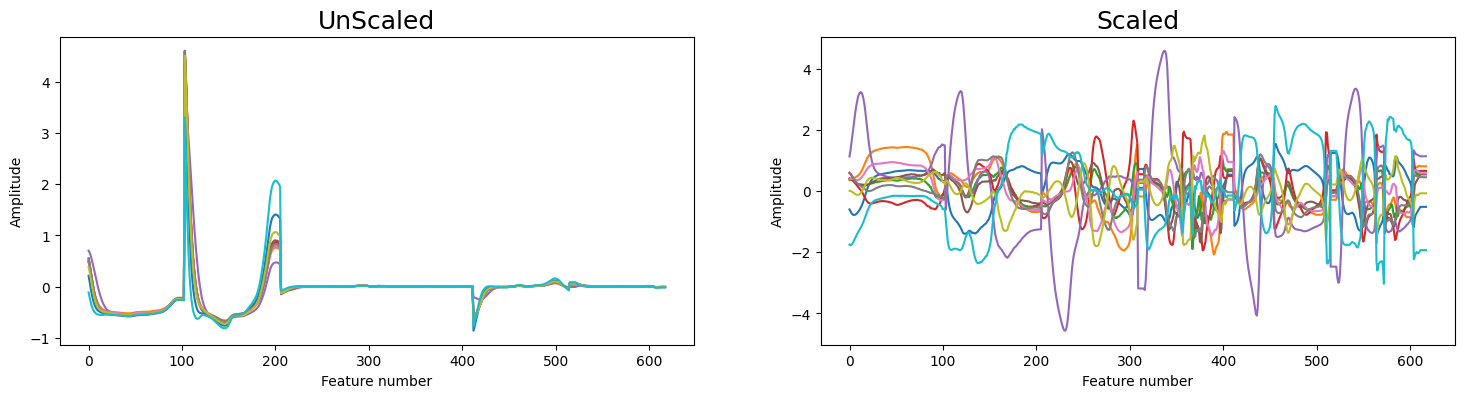

In [8]:
# visualise unscaled and scaled data
plt.figure(figsize=(18,4))

# left panel
plt.subplot(121)
plt.title("UnScaled", fontsize=18)
plt.plot(d["x_train_raw"][:10].T)
plt.ylabel("Amplitude")
plt.xlabel("Feature number")

# right panel
plt.subplot(122)
plt.title("Scaled", fontsize=18)
plt.plot(d["x_train_scaled"][:10].T)
plt.ylabel("Amplitude")
plt.xlabel("Feature number")

plt.show()

## 2.0 Build Models

### 2.1 PLS Anderson et al. (2020) and Mishra & Passos (2021)

In [9]:
model = "PLS"
for td in ("train", "cal"):
    print(f"training_dataset: {td}")
    model_pls, meta_pls = models.build_pls(
        x_train=d[f"x_{td}"],
        y_train=d[f"y_{td}"]
    )
    specs_pls = {
        "model": model,
        "created": dt.datetime.now(),
        **params,
        "training_dataset": td,
        "validation_dataset": None,
        "metrics": {},
        "training_meta": meta_pls,
    }
    evaluation.model_stats(
        model_object=model_pls,
        model_specs=specs_pls,
        data_dict=d,
        save=SAVE_RESULTS,
    )
    break

training_dataset: train
Error Metrics: 		 Cal 		 Tune 		 Test
R2: 				 0.782 		 0.782 		 0.752
RMSE: 				 1.121 		 1.134 		 1.328
SIG: 				  		  		 True


{'model': 'PLS', 'created': datetime.datetime(2024, 2, 7, 12, 51, 35, 525790), 'preprocessing': 'mishra', 'set_split': 'mishra_with_outliers', 'training_order': 'mishra', 'include_mishra_outliers': True, 'x_scaled': False, 'training_dataset': 'train', 'validation_dataset': None, 'metrics': {'train': {'r2': 0.7821499394292406, 'rmse': 1.125092769308084, 'sep': 1.125147693410209, 'bias': -1.1463857513591151e-14, 'rpd': 2.142501612660676, 'prediction_time': datetime.timedelta(microseconds=17584), 'prediction_time_avg': datetime.timedelta(microseconds=2)}, 'cal': {'r2': 0.7821456075893951, 'rmse': 1.120716469370841, 'sep': 1.120786231853481, 'bias': -0.005168605164674913, 'rpd': 2.1425030966872596, 'prediction_time': datetime.timedelta(microseconds=16663), 'prediction_time_avg': datetime.timedelta(microseconds=2)}, 'tune': {'r2': 0.78197

### 2.2 ANN Anderson et al. (2020)

training_dataset: train
Epoch 1/10000
81/81 [==============================] - 0s 830us/step - loss: 165.5364 - mse: 165.5364 - lr: 0.0050
Epoch 2/10000
81/81 [==============================] - 0s 1ms/step - loss: 119.7785 - mse: 119.7785 - lr: 0.0050
Epoch 3/10000
81/81 [==============================] - 0s 836us/step - loss: 81.8884 - mse: 81.8884 - lr: 0.0050
Epoch 4/10000
81/81 [==============================] - 0s 833us/step - loss: 47.7726 - mse: 47.7726 - lr: 0.0050
Epoch 5/10000
81/81 [==============================] - 0s 832us/step - loss: 28.4571 - mse: 28.4571 - lr: 0.0050
Epoch 6/10000
81/81 [==============================] - 0s 833us/step - loss: 17.5984 - mse: 17.5984 - lr: 0.0050
Epoch 7/10000
81/81 [==============================] - 0s 833us/step - loss: 11.5791 - mse: 11.5791 - lr: 0.0050
Epoch 8/10000
81/81 [==============================] - 0s 822us/step - loss: 8.4515 - mse: 8.4515 - lr: 0.0050
Epoch 9/10000
81/81 [==============================] - 0s 1ms/step - los

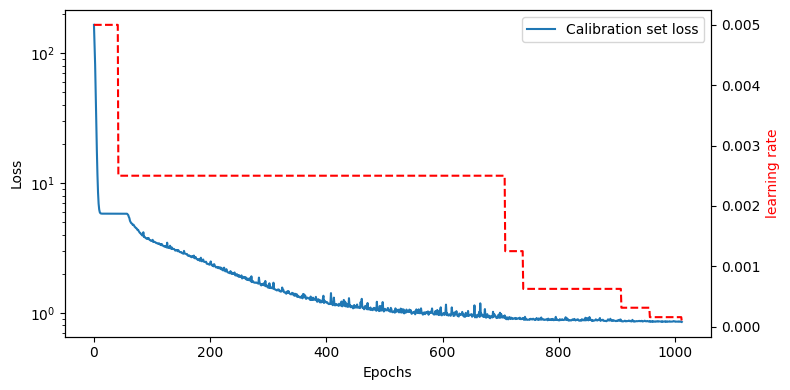

46/46 [==============================] - 0s 359us/step
Error Metrics: 		 Cal 		 Tune 		 Test
R2: 				 0.851 		 0.854 		 0.86
RMSE: 				 0.928 		 0.927 		 1.0
SIG: 				  		  		 True


{'model': 'ANN', 'created': datetime.datetime(2024, 2, 7, 12, 53, 6, 891708), 'preprocessing': 'mishra', 'set_split': 'mishra_with_outliers', 'training_order': 'mishra', 'include_mishra_outliers': True, 'x_scaled': False, 'training_dataset': 'train', 'validation_dataset': None, 'metrics': {'train': {'r2': 0.8518938976086622, 'rmse': 0.9276752449939593, 'sep': 0.9234144040817593, 'bias': -0.08927734894432096, 'rpd': 2.610562210159519, 'prediction_time': datetime.timedelta(microseconds=376760), 'prediction_time_avg': datetime.timedelta(microseconds=37)}, 'cal': {'r2': 0.8506448041421094, 'rmse': 0.927946123047874, 'sep': 0.9231068367741257, 'bias': -0.09529938996453821, 'rpd': 2.601311004110889, 'prediction_time': datetime.timedelta(microseconds=219444), 'prediction_time_avg': datetime.timedelta(microseconds

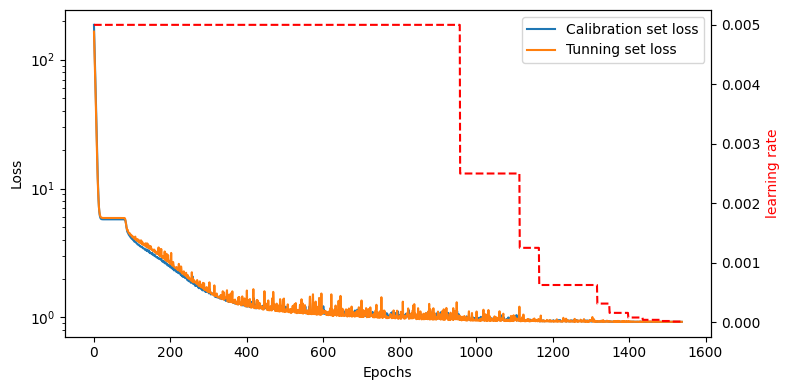

46/46 [==============================] - 0s 977us/step
Error Metrics: 		 Cal 		 Tune 		 Test
R2: 				 0.84 		 0.843 		 0.824
RMSE: 				 0.961 		 0.961 		 1.121
SIG: 				  		  		 True


{'model': 'ANN', 'created': datetime.datetime(2024, 2, 7, 12, 56, 12, 9466), 'preprocessing': 'mishra', 'set_split': 'mishra_with_outliers', 'training_order': 'mishra', 'include_mishra_outliers': True, 'x_scaled': False, 'training_dataset': 'cal', 'validation_dataset': 'tune', 'metrics': {'train': {'r2': 0.840974784894502, 'rmse': 0.9612635771109596, 'sep': 0.9610723871548449, 'bias': -0.02139406682130908, 'rpd': 2.5082717803902734, 'prediction_time': datetime.timedelta(microseconds=474021), 'prediction_time_avg': datetime.timedelta(microseconds=46)}, 'cal': {'r2': 0.8396901088512224, 'rmse': 0.9613748428909696, 'sep': 0.9609074173488693, 'bias': -0.03214190915449485, 'rpd': 2.498979536546454, 'prediction_time': datetime.timedelta(microseconds=221421), 'prediction_time_avg': datetime.timedelta(microsecon

In [10]:
model = "ANN"
for td in ("train", "cal"):
    print(f"training_dataset: {td}")
    if td == "train":
        model_ann, meta_ann = models.build_ann(
            x_train=d["x_train"],
            y_train=d["y_train"],
        )
    else:
        model_ann, meta_ann = models.build_ann(
            x_train=d["x_cal"],
            y_train=d[f"y_cal"],
            x_val=d["x_tune"],
            y_val=d["y_tune"],
        )

    specs_ann = {
        "model": model,
        "created": dt.datetime.now(),
        **params,
        "training_dataset": td,
        "validation_dataset": None if td == "train" else "tune",
        "metrics": {},
        "training_meta": meta_ann,
    }
    evaluation.model_stats(
        model_object=model_ann,
        model_specs=specs_ann,
        data_dict=d,
        save=SAVE_RESULTS,
    )

### 2.3 CNN Mishra & Passos (2021)

training_dataset: train
Epoch 1/750
81/81 [==============================] - 1s 6ms/step - loss: 18.4494 - mse: 17.6889 - lr: 0.0050
Epoch 2/750
81/81 [==============================] - 1s 7ms/step - loss: 6.5700 - mse: 5.9355 - lr: 0.0050
Epoch 3/750
81/81 [==============================] - 1s 7ms/step - loss: 6.3523 - mse: 5.7881 - lr: 0.0050
Epoch 4/750
81/81 [==============================] - 1s 8ms/step - loss: 6.3199 - mse: 5.7979 - lr: 0.0050
Epoch 5/750
81/81 [==============================] - 1s 7ms/step - loss: 6.4563 - mse: 5.9623 - lr: 0.0050
Epoch 6/750
81/81 [==============================] - 1s 7ms/step - loss: 6.0661 - mse: 5.5898 - lr: 0.0050
Epoch 7/750
81/81 [==============================] - 1s 6ms/step - loss: 5.8113 - mse: 5.3423 - lr: 0.0050
Epoch 8/750
81/81 [==============================] - 1s 7ms/step - loss: 5.6097 - mse: 5.1358 - lr: 0.0050
Epoch 9/750
81/81 [==============================] - 1s 7ms/step - loss: 5.3578 - mse: 4.8627 - lr: 0.0050
Epoch 10/75

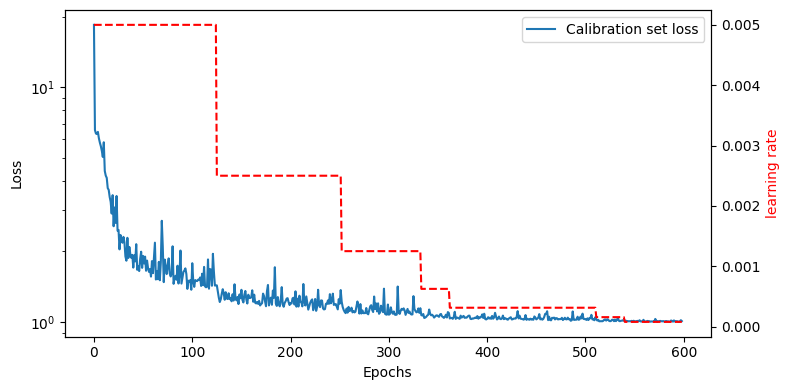

46/46 [==============================] - 0s 5ms/step
Error Metrics: 		 Cal 		 Tune 		 Test
R2: 				 0.87 		 0.869 		 0.824
RMSE: 				 0.867 		 0.88 		 1.118
SIG: 				  		  		 True


{'model': 'CNN', 'created': datetime.datetime(2024, 2, 7, 13, 7, 2, 505440), 'preprocessing': 'mishra', 'set_split': 'mishra_with_outliers', 'training_order': 'mishra', 'include_mishra_outliers': True, 'x_scaled': False, 'training_dataset': 'train', 'validation_dataset': None, 'metrics': {'train': {'r2': 0.8694549937041982, 'rmse': 0.8709427791486732, 'sep': 0.870983229343378, 'bias': 0.0018974293929798446, 'rpd': 2.7677120137320594, 'prediction_time': datetime.timedelta(seconds=2, microseconds=188163), 'prediction_time_avg': datetime.timedelta(microseconds=214)}, 'cal': {'r2': 0.869733396142676, 'rmse': 0.866620861455466, 'sep': 0.8666564889055018, 'bias': -0.00690801227878673, 'rpd': 2.770749429803621, 'prediction_time': datetime.timedelta(seconds=1, microseconds=386518), 'prediction_time_avg': datetime.t

In [11]:
model = "CNN"
for td in ("train", "cal"):
    print(f"training_dataset: {td}")
    if td == "train":
        model_cnn, meta_cnn = models.build_cnn(
            x_train=d["x_train"],
            y_train=d["y_train"],
        )
    else:
        model_cnn, meta_cnn = models.build_cnn(
            x_train=d["x_cal"],
            y_train=d["y_cal"],
            x_val=d["x_tune"],
            y_val=d["y_tune"],
        )

    specs_cnn = {
        "model": model,
        "created": dt.datetime.now(),
        **params,
        "training_dataset": td,
        "validation_dataset": None if td == "train" else "tune",
        "metrics": {},
        "training_meta": meta_cnn,
    }
    evaluation.model_stats(
        model_object=model_cnn,
        model_specs=specs_cnn,
        data_dict=d,
        save=SAVE_RESULTS,
    )
    break